In [1]:
import pandas as pd
import sqlalchemy as sa
import pyodbc
import numpy as np
pd.options.display.float_format = '${:,.0f}'.format

In [2]:
engine = sa.create_engine('mssql+pyodbc://(localdb)\MSSQLLocalDB/vpolyanchikov?driver=ODBC Driver 17 for SQL Server')

In [3]:
def read_sql(query, engine):
    df = pd.read_sql_query(query, engine)
    engine.dispose()
    return df

In [4]:
def execute_sql(query, engine):
    conn = engine.connect()
    result = conn.execute(query + "; commit;")
    engine.dispose()
    return result

In [5]:
def to_sql(df, tables, engine, schema='dbo',if_exist='append'):
    df.to_sql(name=tables, con=engine,
                  schema=schema, if_exists=if_exist, index=0)
    engine.dispose()
    return

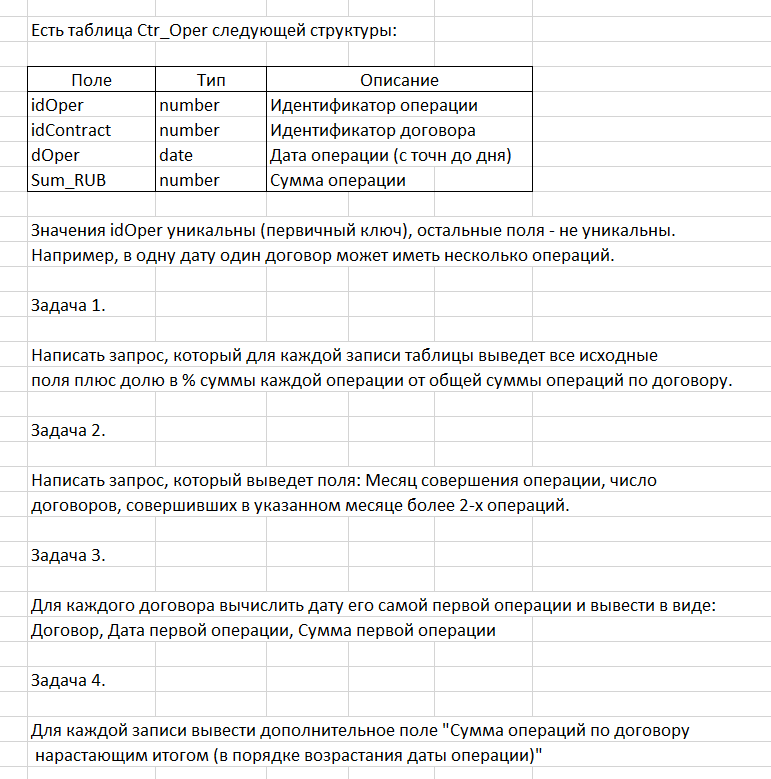

In [16]:
from PIL import Image
Image.open('Задание.png')

### Загружаем данные в таблицу

In [6]:
df = pd.read_excel('dfs.xlsx', sheet_name ='Oper')

In [7]:
df

,idOper,idContract,dOper,Sum_RUB
0,1,2,2020-04-02,353
1,2,4,2021-05-03,850
2,20,5,2021-12-09,1357
3,3,1,2022-01-09,1810
4,4,4,2022-03-08,753
5,5,2,2022-04-02,1000
6,6,3,2022-04-04,737
7,7,3,2022-04-04,9
8,8,4,2022-04-07,1918
9,9,2,2022-05-03,666


In [10]:
execute_sql("""CREATE TABLE Ctr_Oper
                (idOper int primary key,
                idContract int,
                dOper date,
                Sum_Rub int)
                """, engine)

In [9]:
execute_sql("""DROP TABLE IF EXISTS Ctr_Oper""", engine)

In [11]:
to_sql(df, 'Ctr_Oper', engine)

#### Задача 1

In [12]:
q = """SELECT *,
       Sum_Rub * 100 / SUM(Sum_Rub) OVER (PARTITION BY idContract) AS "Share, %"
FROM Ctr_Oper;"""
read_sql(q, engine)

,idOper,idContract,dOper,Sum_Rub,"Share, %"
0,3,1,2022-01-09,1810,41
1,10,1,2022-08-01,500,11
2,15,1,2022-08-08,2026,46
3,1,2,2020-04-02,353,17
4,5,2,2022-04-02,1000,49
5,9,2,2022-05-03,666,32
6,6,3,2022-04-04,737,88
7,7,3,2022-04-04,9,1
8,12,3,2022-08-06,86,10
9,13,4,2022-08-06,970,7


#### Задача 2

In [13]:
q = """WITH a AS
  (SELECT Datename(MONTH, dOPer) AS Month_name,
          idContract,
          COUNT(idOper) OVER (PARTITION BY idContract,
                                           Datename(MONTH, dOPer)) AS cnt_contracts
   FROM Ctr_Oper
   GROUP BY Datename(MONTH, dOPer),
            idContract,
            idOper)
SELECT Month_name,
       count(distinct(idcontract)) AS cnt_diff_contracts_more_than_2_actions
FROM a
WHERE cnt_contracts > 2
GROUP BY month_name;"""
read_sql(q, engine)

,Month_name,cnt_diff_contracts_more_than_2_actions
0,August,1
1,December,1


#### Задача 3

In [14]:
q = """SELECT top 1 WITH ties idContract,
                  dOper,
                  Sum_rub
FROM Ctr_Oper
ORDER BY ROW_NUMBER() OVER(PARTITION BY idContract
                           ORDER BY dOper);"""
read_sql(q, engine)

,idContract,dOper,Sum_rub
0,4,2021-05-03,850
1,1,2022-01-09,1810
2,2,2020-04-02,353
3,3,2022-04-04,737
4,5,2021-12-09,1357


#### Задача 4

In [15]:
q = """SELECT *,
       sum(Sum_Rub) OVER (PARTITION BY idContract
                          ORDER BY dOper) AS cumSum
FROM Ctr_Oper
ORDER BY dOper;"""
read_sql(q, engine)

,idOper,idContract,dOper,Sum_Rub,cumSum
0,1,2,2020-04-02,353,353
1,2,4,2021-05-03,850,850
2,20,5,2021-12-09,1357,1357
3,3,1,2022-01-09,1810,1810
4,4,4,2022-03-08,753,1603
5,5,2,2022-04-02,1000,1353
6,6,3,2022-04-04,737,746
7,7,3,2022-04-04,9,746
8,8,4,2022-04-07,1918,3521
9,9,2,2022-05-03,666,2019
